[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/cmamega.ipynb)

# Optimizing with CMA-MEGA in Jax

This notebook shows how to use QDax to find diverse and performing parameters on the Rastrigin problem with [CMA-MEGA](https://arxiv.org/pdf/2106.03894.pdf). It can be run locally or on Google Colab. We recommand to use a GPU. This notebook will show:

- how to define the problem
- how to create a cma-mega emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process

In [1]:
import jax 
import jax.numpy as jnp

try:
    import flax
except:
    !pip install --no-deps git+https://github.com/google/flax.git@v0.4.1 |tail -n 1
    import flax

try:
    import chex
except:
    !pip install --no-deps git+https://github.com/deepmind/chex.git@v0.1.3 |tail -n 1
    import chex

try:
    import jumanji
except:
    !pip install "jumanji==0.2.2"
    import jumanji

try:
    import qdax
except:
    !pip install --no-deps git+https://github.com/adaptive-intelligent-robotics/QDax@main |tail -n 1
    import qdax

from qdax.core.map_elites import MAPElites
from qdax.core.emitters.cma_mega_emitter import CMAMEGAEmitter
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
from qdax.utils.plotting import plot_map_elites_results

from typing import Dict

2025-11-23 20:34:36.529648: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/home/tin/anaconda3/envs/mix-me/lib/python3.10/site-packages/brax/v1/jumpy.py:34: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(
/home/tin/anaconda3/envs/mix-me/lib/python3.10/site-packages/brax/v1/__init__.py:26: DeprecationWarning: brax.v1 is deprecated and will be removed in a future release.
  warnings.warn(


## Set the hyperparameters

Most hyperparameters are similar to those introduced in [Differentiable Quality Diversity paper](https://arxiv.org/pdf/2106.03894.pdf).

In [2]:
#@title QD Training Definitions Fields
#@markdown ---
num_iterations = 2000 #@param {type:"integer"}
num_dimensions = 1000 #@param {type:"integer"}
num_centroids = 10000 #@param {type:"integer"}
minval = -5.12 #@param {type:"number"}
maxval = 5.12 #@param {type:"number"}
batch_size = 16 #@param {type:"integer"}
learning_rate = 1 #@param {type:"number"}
es_noise = 0.01
sigma_g = 3.16 #@param {type:"number"} # square root of 10, the value given in the paper
mirror_sampling = False
exact_gradient = True
#@markdown ---

## Defines the scoring function: rastrigin

As we are in the Differentiable QD setting, the scoring function does not only retrieve the fitness and descriptors, but also the gradients.

In [3]:
def rastrigin_scoring(x: jnp.ndarray):
    return -(10 * x.shape[-1] + jnp.sum((x+minval*0.4)**2 - 10 * jnp.cos(2 * jnp.pi * (x+minval*0.4))))

def clip(x: jnp.ndarray):
    return x*(x<=maxval)*(x>=+minval) + maxval/x*((x>maxval)+(x<+minval))

def _rastrigin_descriptor_1(x: jnp.ndarray):
    return jnp.mean(clip(x[:x.shape[-1]//2]))

def _rastrigin_descriptor_2(x: jnp.ndarray):
    return jnp.mean(clip(x[x.shape[-1]//2:]))

def rastrigin_descriptors(x: jnp.ndarray):
    return jnp.array([_rastrigin_descriptor_1(x), _rastrigin_descriptor_2(x)])

rastrigin_grad_scores = jax.grad(rastrigin_scoring)

In [4]:
def scoring_function(x):
    scores, descriptors = rastrigin_scoring(x), rastrigin_descriptors(x)
    gradients = jnp.array([rastrigin_grad_scores(x), jax.grad(_rastrigin_descriptor_1)(x), jax.grad(_rastrigin_descriptor_2)(x)]).T
    gradients = jnp.nan_to_num(gradients)

    # Compute normalized gradients
    norm_gradients = jax.tree_util.tree_map(
        lambda x: jnp.linalg.norm(x, axis=1, keepdims=True),
        gradients,
    )
    grads = jax.tree_util.tree_map(
        lambda x, y: x / y, gradients, norm_gradients
    )
    grads = jnp.nan_to_num(grads)
    extra_scores = {
        'gradients': gradients,
        'normalized_grads': grads
    }

    return scores, descriptors, extra_scores

def scoring_fn(x, random_key):
    fitnesses, descriptors, extra_scores = jax.vmap(scoring_function)(x)
    return fitnesses, descriptors, extra_scores, random_key

## Define the metrics that will be used

In [5]:
worst_objective = rastrigin_scoring(-jnp.ones(num_dimensions) * 5.12)
best_objective = rastrigin_scoring(jnp.ones(num_dimensions) * 5.12 * 0.4)


def metrics_fn(repertoire: MapElitesRepertoire) -> Dict[str, jnp.ndarray]:

    # get metrics
    grid_empty = repertoire.fitnesses == -jnp.inf
    adjusted_fitness = (
        (repertoire.fitnesses - worst_objective) / (best_objective - worst_objective)
    )
    qd_score = jnp.sum(adjusted_fitness, where=~grid_empty) / num_centroids
    coverage = 100 * jnp.mean(1.0 - grid_empty)
    max_fitness = jnp.max(adjusted_fitness)
    return {"qd_score": qd_score, "max_fitness": max_fitness, "coverage": coverage}

## Define the initial population, the emitter and the MAP Elites instance

The emitter is defined using the CMAMEGA emitter class. This emitter is given to a MAP-Elites instance to create an instance of the CMA-MEGA algorithm.

In [6]:
random_key = jax.random.PRNGKey(2)
# no initial population - give all the same value as emitter init value
initial_population = jax.random.uniform(random_key, shape=(batch_size, num_dimensions)) * 0.

centroids, random_key = compute_cvt_centroids(
    num_descriptors=2, 
    num_init_cvt_samples=10000, 
    num_centroids=num_centroids, 
    minval=minval, 
    maxval=maxval,
    random_key=random_key,
)

emitter = CMAMEGAEmitter(
    scoring_function=scoring_fn,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_descriptors=2,
    centroids=centroids,
    sigma_g=sigma_g,
    exact_gradient=exact_gradient,
    es_batch_size=batch_size,
    es_noise=es_noise,
    mirrored_sampling=mirror_sampling
)

map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=emitter,
    metrics_function=metrics_fn
)

In [7]:
repertoire, emitter_state, random_key = map_elites.init(initial_population, centroids, random_key)

/home/tin/Desktop/HaiDang/RL/Mix-ME/MA-QDax/qdax/core/map_elites.py:82: UserWarning: This type of repertoire does not store the extra scores computed by the scoring function
  repertoire = MapElitesRepertoire.init(


(1, 1000)
coeffs shape Traced<ShapedArray(float32[16,3])>with<DynamicJaxprTrace(level=2/0)>, grads shape (1000, 3)
update_grad shape Traced<ShapedArray(float32[16,1000])>with<DynamicJaxprTrace(level=2/0)>
normalized_gradients shape (1, 1000, 3)


In [8]:
%%time

(repertoire, emitter_state, random_key,), metrics = jax.lax.scan(
    map_elites.scan_update,
    (repertoire, emitter_state, random_key),
    (),
    length=num_iterations,
)

emit coeffs shape Traced<ShapedArray(float32[16,3])>with<DynamicJaxprTrace(level=4/0)>, emit grads shape (1000, 3)
coeffs shape Traced<ShapedArray(float32[16,3])>with<DynamicJaxprTrace(level=4/0)>, grads shape (1000, 3)
update_grad shape Traced<ShapedArray(float32[16,1000])>with<DynamicJaxprTrace(level=4/0)>
normalized_gradients shape (1, 1000, 3)
CPU times: user 2.19 s, sys: 53.8 ms, total: 2.25 s
Wall time: 2.07 s


In [9]:
for k, v in metrics.items():
    print(f"{k} after {num_iterations * batch_size}: {v[-1]}")

coverage after 32000: 45.41999816894531
imp_cross after 32000: 0.0
imp_mut after 32000: 0.0
imp_var after 32000: 2071.3515625
max_fitness after 32000: 0.9999999403953552
qd_score after 32000: 0.05397709086537361
succ_cross after 32000: 0
succ_mut after 32000: 0
succ_var after 32000: 1


## Visualise results

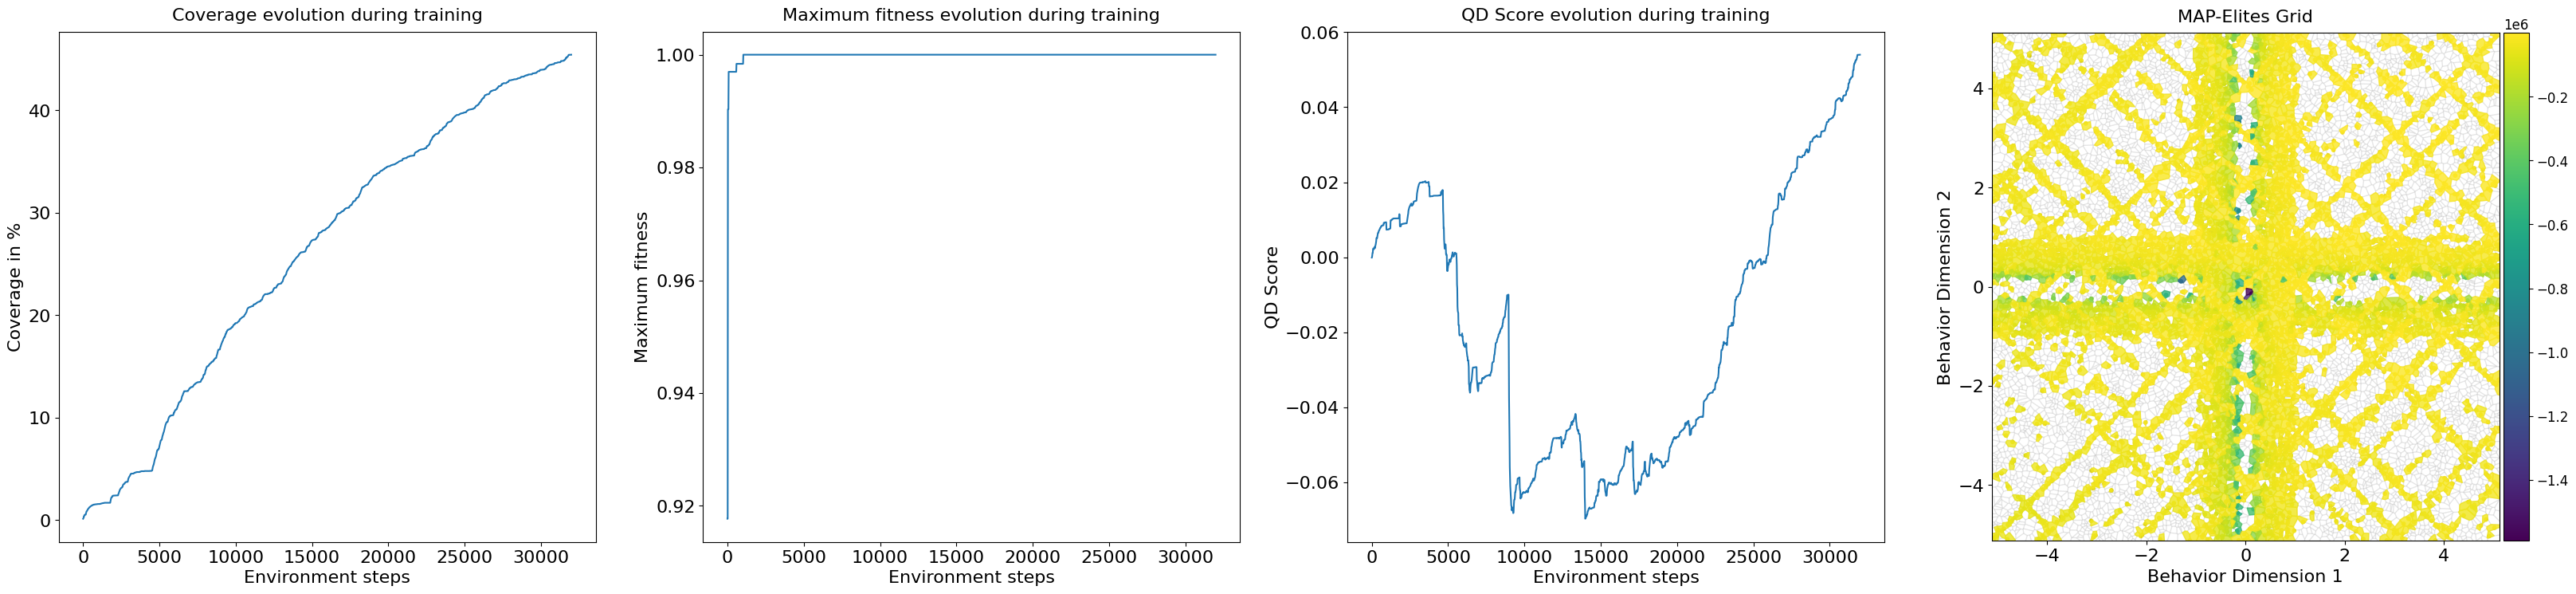

In [10]:
%matplotlib inline
#@title Visualization

# create the x-axis array
env_steps = jnp.arange(num_iterations) * batch_size

# create the plots and the grid
fig, axes = plot_map_elites_results(
    env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_bd=minval, max_bd=maxval
)